In [1]:
import sys 
from pathlib import Path
project_root = (Path.cwd() / "../../").resolve()
sys.path.append(str(project_root))

In [2]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product
import numpy as np


In [3]:
data_path = project_root / "data"

# Loading The Data

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id**  an Id that represents a (Store, Date) duple within the test set
* **Store**  a unique Id for each store
* **Sales**  the turnover for any given day (this is what you are predicting)
* **Customers**  the number of customers on a given day
* **Open**  an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday**  indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday**  indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType**  differentiates between 4 different store models: a, b, c, d
* **Assortment**  describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance**  distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]**  gives the approximate year and month of the time the nearest competitor was opened
* **Promo**  indicates whether a store is running a promo on that day
* **Promo2**  Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]**  describes the year and calendar week when the store started participating in Promo2
* **PromoInterval**  describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [4]:

# load train data
from rossmann.model.data_loader import load_instances_csv, load_stores_csv
from rossmann.model.prepare_data import prepare_stores
from rossmann.model.pipeline.filter import TopStoreSelector
from rossmann.model.pipeline import make_feature_extractor
from sklearn.compose import make_column_selector

def range(col):
    return max(col) - min(col)

summarizers = ["min", "max", "count", "nunique", range]

## Training Data
### Load and conver to Right Types

In [5]:
train = load_instances_csv(data_path / "train.csv")
subset_train = TopStoreSelector(top_percent=0.1).fit_transform(train)

#test = train = load_instances_csv(data_path / "test.csv")

stores = load_stores_csv(data_path / "store.csv")

In [6]:
prepared_stores = prepare_stores(train, stores)
prepared_stores.info()
print(prepared_stores.describe())
prepared_stores.index.to_frame().agg(summarizers)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   StoreType             1115 non-null   category      
 1   Assortment            1115 non-null   category      
 2   CompetitionDistance   1115 non-null   float64       
 3   Promo2                1115 non-null   bool          
 4   PromoInterval         1115 non-null   object        
 5   CompetitionOpenSince  1115 non-null   datetime64[ns]
 6   Promo2Since           571 non-null    datetime64[ns]
 7   HolidayGroup          1115 non-null   category      
dtypes: bool(1), category(3), datetime64[ns](2), float64(1), object(1)
memory usage: 48.6+ KB
       CompetitionDistance
count          1115.000000
mean           5396.614350
std            7654.513635
min              20.000000
25%             720.000000
50%            2325.000000
75%            6875.000000
max 

,Store
min,1
max,1115
count,1115
nunique,1115
range,1114


In [7]:
print(subset_train.info())
print(subset_train.describe())
print(subset_train.index.to_frame().agg(["min", "max", "count", "nunique", range]))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49742 entries, (84, Timestamp('2015-07-31 00:00:00')) to (1114, Timestamp('2013-01-01 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DayOfWeek      49742 non-null  int64   
 1   Sales          49742 non-null  int64   
 2   Customers      49742 non-null  int64   
 3   Open           49742 non-null  bool    
 4   Promo          49742 non-null  bool    
 5   StateHoliday   49742 non-null  category
 6   SchoolHoliday  49742 non-null  bool    
dtypes: bool(3), category(1), int64(3)
memory usage: 1.5 MB
None
          DayOfWeek         Sales     Customers
count  49742.000000  49742.000000  49742.000000
mean       3.997929  11771.129629   1570.986410
std        1.997369   6265.248671    937.708342
min        1.000000      0.000000      0.000000
25%        2.000000   9210.000000   1097.000000
50%        4.000000  12091.500000   1534.000000
75%        6.0

In [8]:
feature_extractor = make_feature_extractor(prepared_stores)
subset_train_extracted_features = feature_extractor.fit_transform(subset_train)

In [18]:
print(subset_train_extracted_features.info())
subset_train_extracted_features

# TODO holiday group is not in the train data?

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49742 entries, (84, Timestamp('2015-07-31 00:00:00')) to (1114, Timestamp('2013-01-01 00:00:00'))
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DayOfWeek                 49742 non-null  int64   
 1   Sales                     49742 non-null  int64   
 2   Customers                 49742 non-null  int64   
 3   Open                      49742 non-null  bool    
 4   Promo                     49742 non-null  bool    
 5   StateHoliday              49742 non-null  bool    
 6   SchoolHoliday             49742 non-null  bool    
 7   Day                       49742 non-null  int64   
 8   Year                      49742 non-null  int64   
 9   Month                     49742 non-null  int64   
 10  DayOfYear                 49742 non-null  int64   
 11  DaysSinceStart            49742 non-null  int64   
 12  Promo2                    4974

DayOfWeek  Sales  Customers   Open  Promo  StateHoliday  \
Store Date                                                                  
84    2015-07-31          5  14949       1439   True   True         False   
      2015-07-30          4  12928       1255   True   True         False   
      2015-07-29          3  15367       1511   True   True         False   
      2015-07-28          2  14892       1383   True   True         False   
      2015-07-27          1  16104       1412   True   True         False   
...                     ...    ...        ...    ...    ...           ...   
1114  2013-01-05          6  18856       3065   True  False         False   
      2013-01-04          5  18371       3036   True  False         False   
      2013-01-03          4  18463       3211   True  False         False   
      2013-01-02          3  20642       3401   True  False         False   
      2013-01-01          2      0          0  False  False          True   

                  SchoolHoliday  Day  Year  Month  DayOfYear  DaysSinceStart  \
Store Date                                                                     
84    2015-07-31           True   31  2015      7        212             941   
      2015-07-30           True   30  2015      7        211             940   
      2015-07-29           True   29  2015      7        210             939   
      2015-07-28           True   28  2015      7        209             938   
      2015-07-27           True   27  2015      7        208             937   
...                         ...  ...   ...    ...        ...             ...   
1114  2013-01-05          False    5  2013      1          5               4   
      2013-01-04           True    4  2013      1          4               3   
      2013-01-03           True    3  2013      1          3               2   
      2013-01-02           True    2  2013      1          2               1   
      2013-01-01           True    1  2013      1          1               0   

                  Promo2  CompetitionOpenSinceDays  CompetitionOpen StoreType  \
Store Date                                                                      
84    2015-07-31   False                       364             True         a   
      2015-07-30   False                       363             True         a   
      2015-07-29   False                       362             True         a   
      2015-07-28   False                       361             True         a   
      2015-07-27   False                       360             True         a   
...                  ...                       ...              ...       ...   
1114  2013-01-05   False                      1069             True         a   
      2013-01-04   False                      1068             True         a   
      2013-01-03   False                      1067             True         a   
      2013-01-02   False                      1066             True         a   
      2013-01-01   False                      1065             True         a   

                 Assortment  CompetitionDistance HolidayGroup  
Store Date                                                     
84    2015-07-31   extended              11810.0            1  
      2015-07-30   extended              11810.0            1  
      2015-07-29   extended              11810.0            1  
      2015-07-28   extended              11810.0            1  
      2015-07-27   extended              11810.0            1  
...                     ...                  ...          ...  
1114  2013-01-05   extended                870.0            7  
      2013-01-04   extended                870.0            7  
      2013-01-03   extended                870.0            7  
      2013-01-02   extended                870.0            7  
      2013-01-01   extended                870.0            7  

[49742 rows x 19 columns]

# Sales Over Time

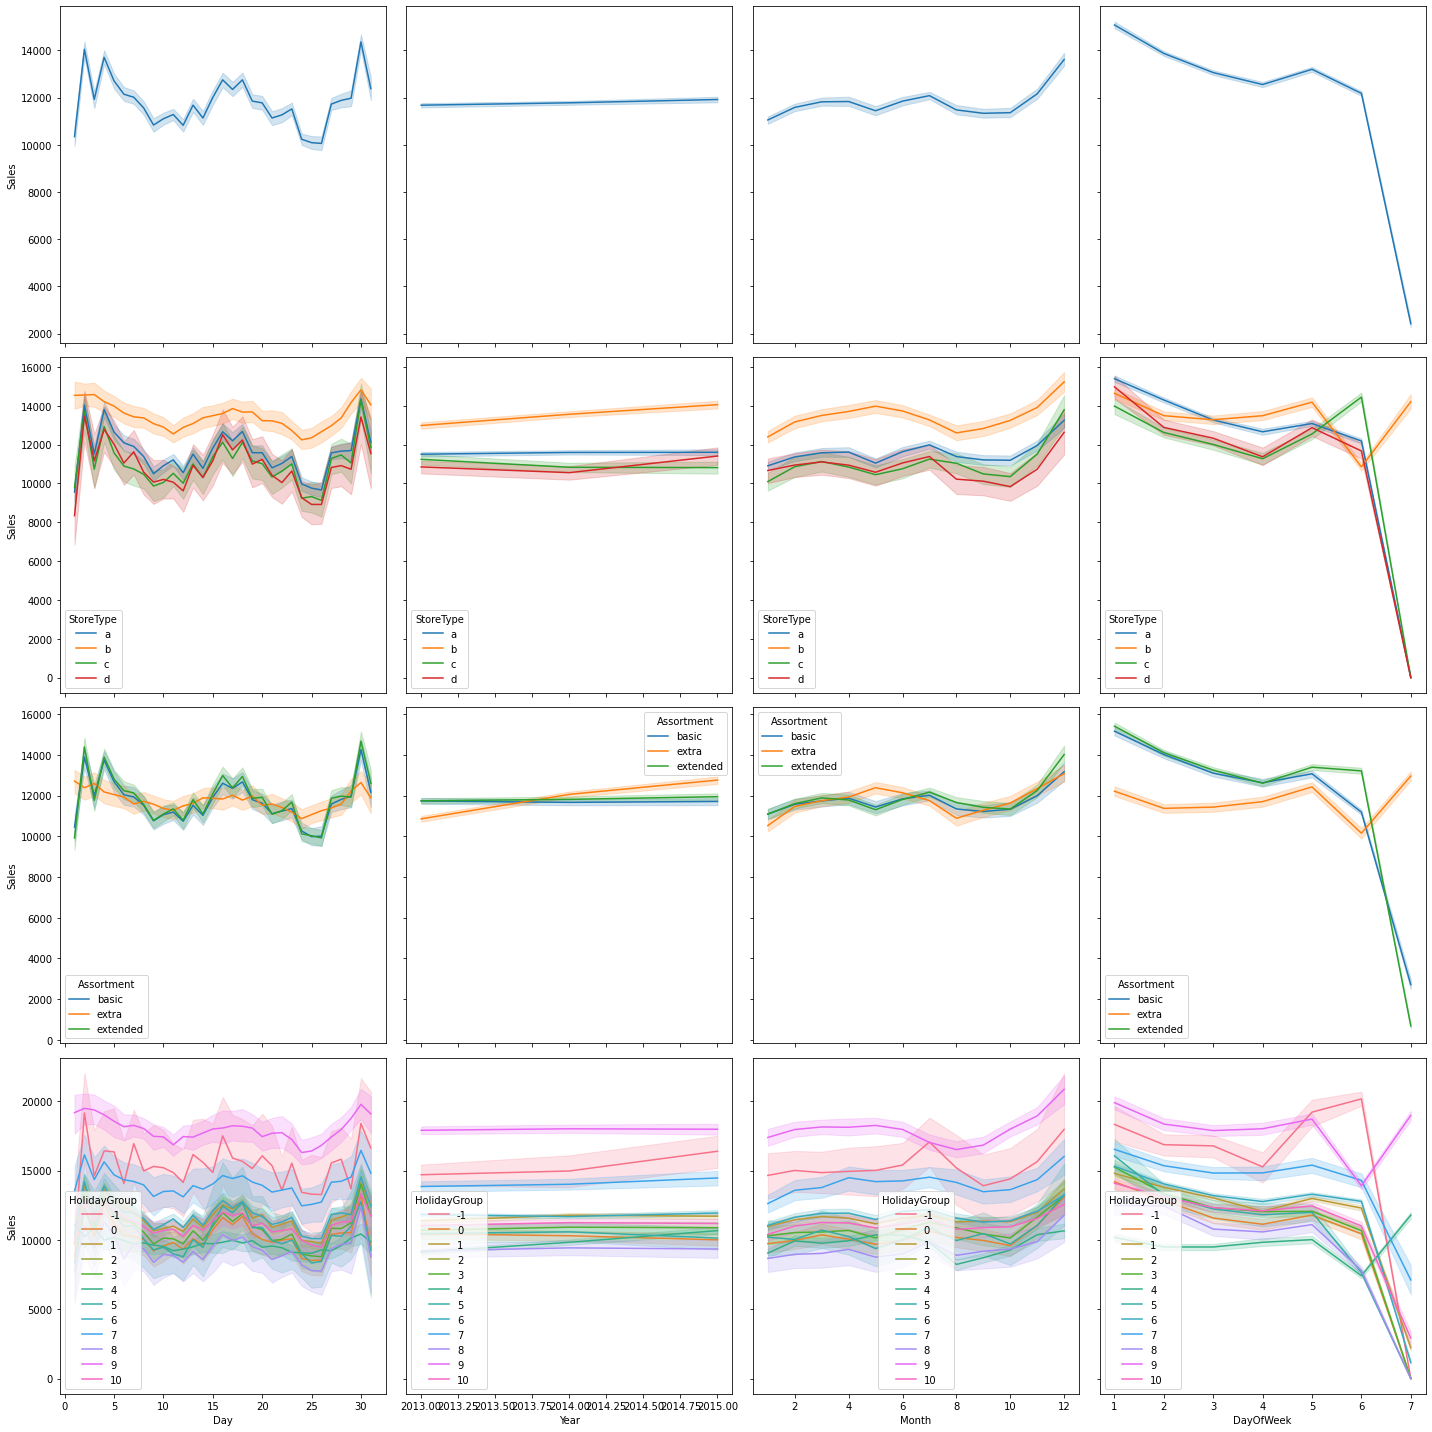

In [19]:
freqs = ["Day", "Year", "Month", "DayOfWeek"]
cats = [None, "StoreType", "Assortment", "HolidayGroup"]

fig, axes = plt.subplots(
    nrows=len(cats), 
    ncols=len(freqs), figsize=(20, 20), sharex="col", sharey="row")
for (cat, freq), ax in zip(product(cats, freqs), axes.flat):
    sns.lineplot(x=freq, y="Sales", data=subset_train_extracted_features, hue=cat, ax=ax)
    

plt.tight_layout()

### Takeaways 
* Day probalby not importat
* StoreType, HolidayGroup and Assort might help

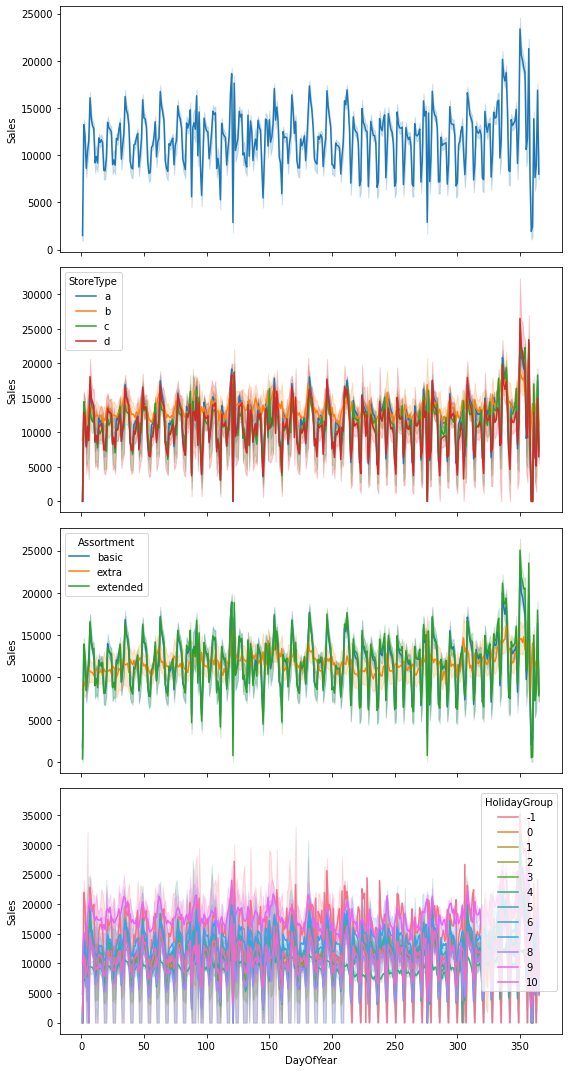

In [20]:
cats = [None, "StoreType", "Assortment", "HolidayGroup"]

fig, axes = plt.subplots(
    nrows=len(cats), figsize=(8, 15), sharex="col", sharey="row")
for cat, ax in zip(cats, axes.flat):
    sns.lineplot(x="DayOfYear", y="Sales", data=subset_train_extracted_features, hue=cat, ax=ax)
    

plt.tight_layout()

## Features Distributions
### Non-Categorical

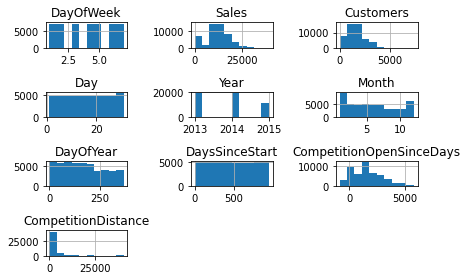

In [21]:


non_cat_sel = make_column_selector(dtype_exclude=[bool, "category"])
non_cat = non_cat_sel(subset_train_extracted_features)
subset_train_extracted_features[non_cat].hist()
plt.tight_layout()

### Takeawys
1. CompetetionDistance: x transform CompetetionDistance to make it more semetric
2. Normalize Continous Fatures: Year, Month, DayOfYear, DayOfWeek 
3. Maybe (depending on classifier) convert StoreTye, HolidayGroup, Assortment to bianry indicators



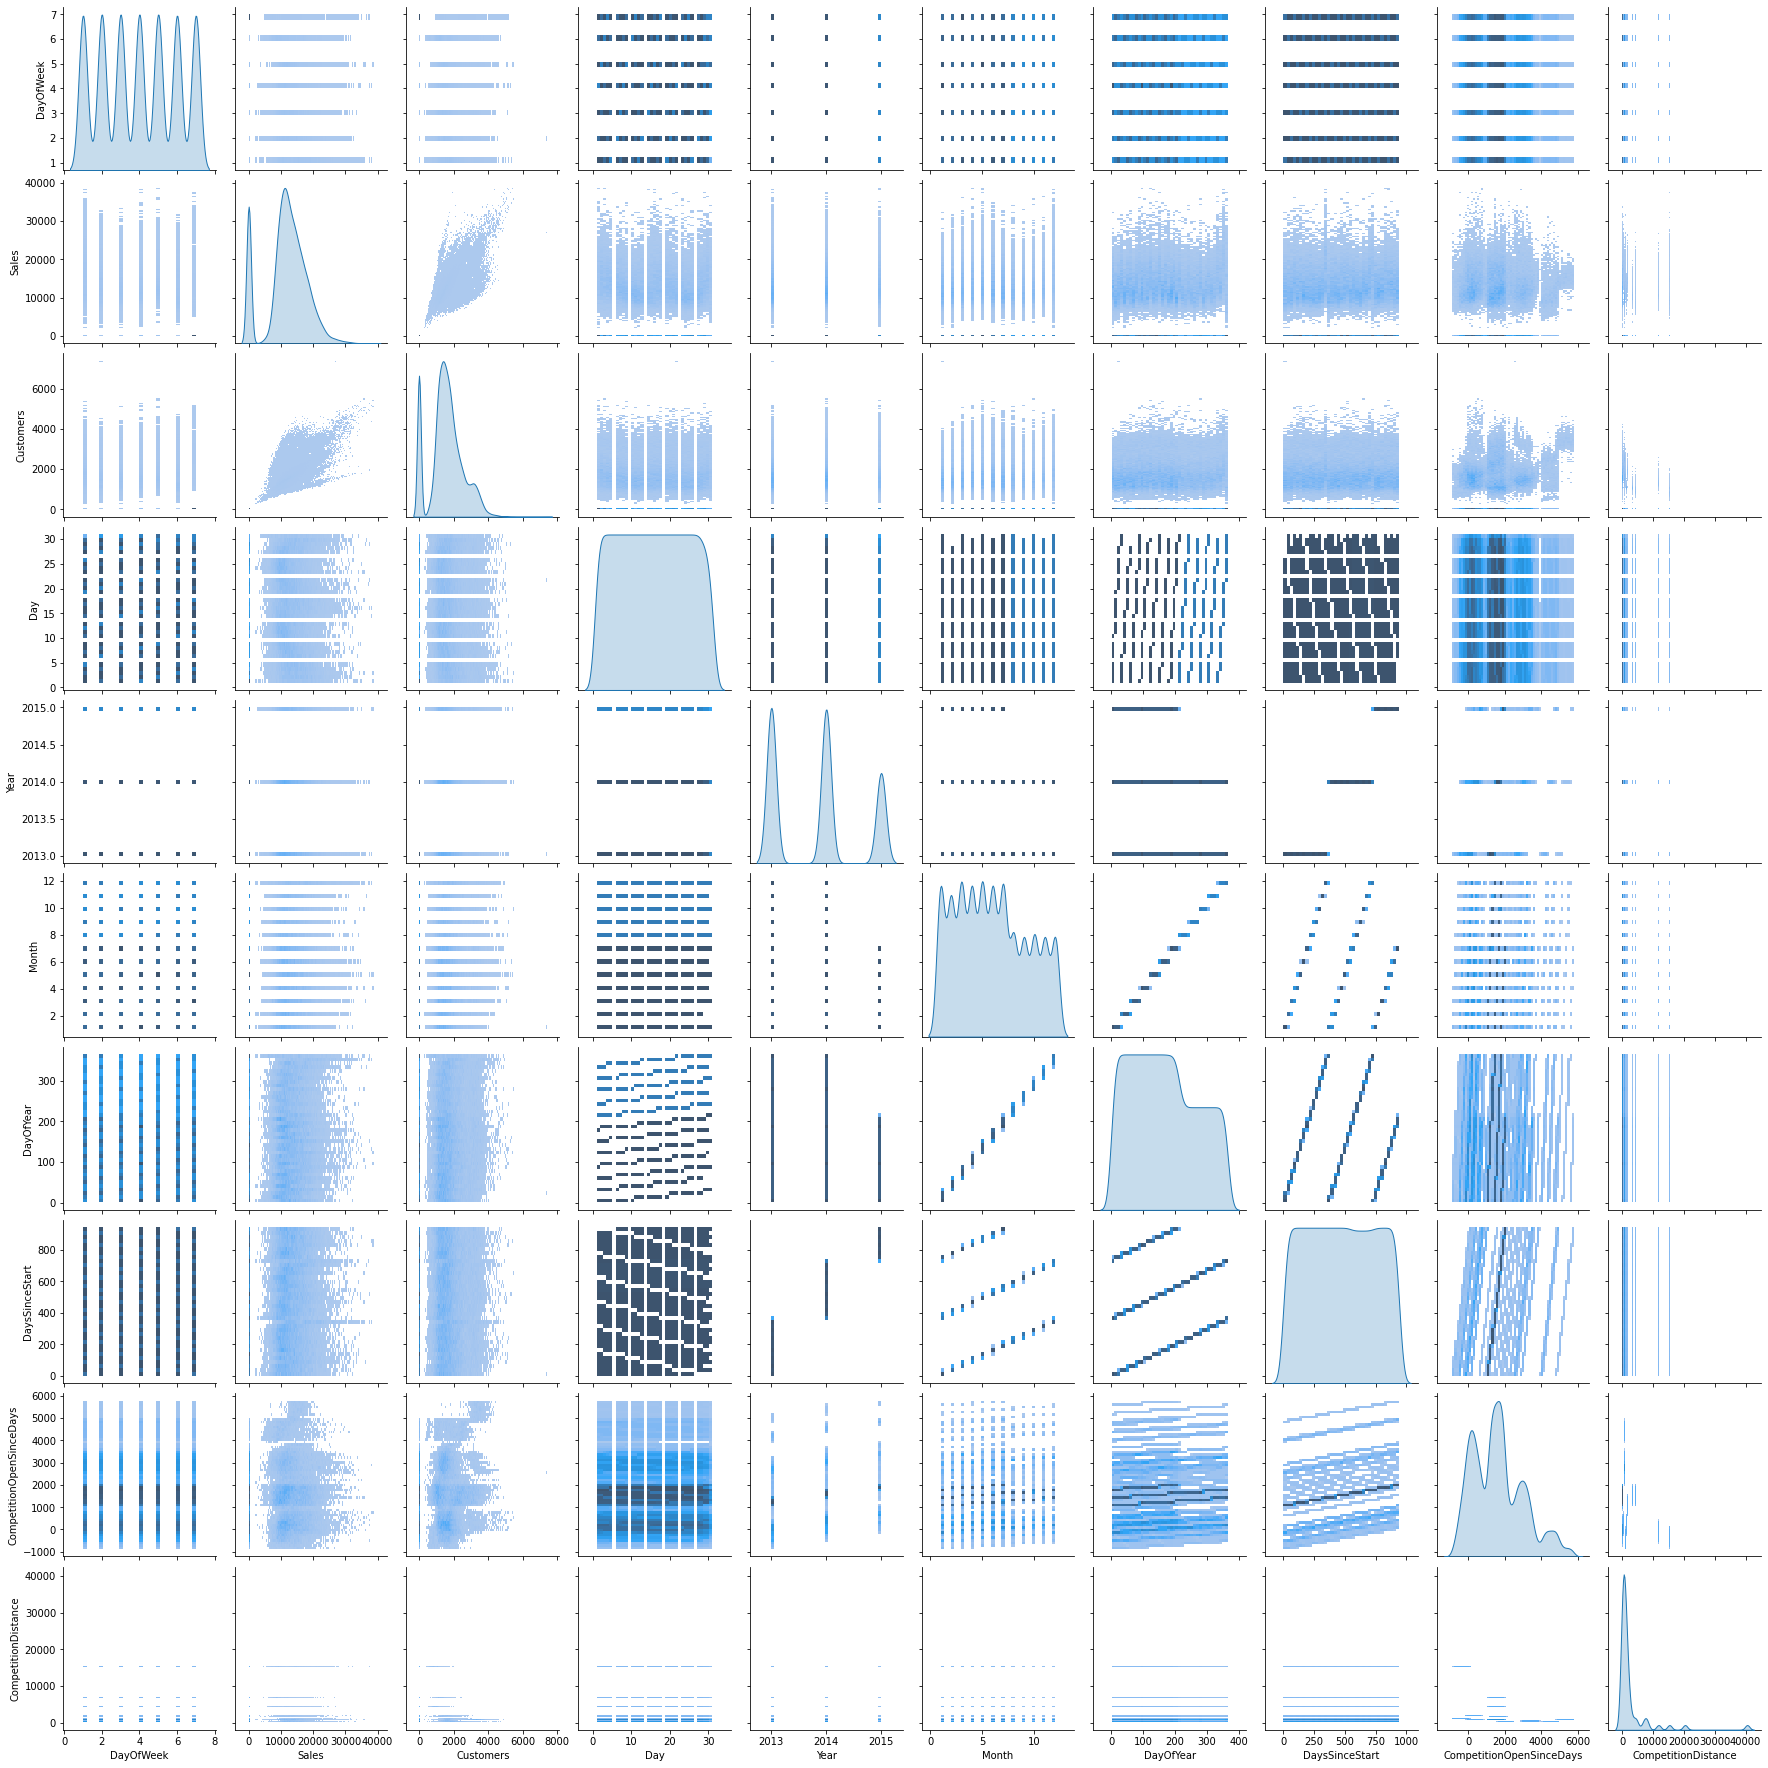

In [22]:
sns.pairplot(subset_train_extracted_features[non_cat], kind='hist', diag_kind='kde')